# ゲート付きRNN

## UGRNN

- 更新ゲートを追加したRNNを実装する
    - UGRNNクラスを実装する
    - 線形変換にはnn.Linearクラスを使用する
    - nn.Moduleを継承する
    - batch firstの形状を想定する. [batch_size, seq_len, hidden_size]
- PytorchにはUGRNNの実装はないので、自前で実装する必要がある
- 基本的なインターフェースはmyRNNと同じ

In [1]:
import torch.nn as nn
class UGRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size

        # 線形変換
        self.transform = nn.Linear(input_size+hidden_size, hidden_size)
        self.update_gate = nn.Linear(input_size+hidden_size, hidden_size)

        # 活性化関数
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()
        
        
    def forward(self, input, h_0=None):
        # input: [batch_size, seq_len, input_size]
        batch_size, self.seq_len, _ = input.size()

        if h_0 is None:
            h_0 = torch.zeros(1, batch_size, self.hidden_size)#.to(device)

        h = h_0.squeeze(0) # [1, batch_size, hidden_size] -> [batch_size, hidden_size]
        outputs = []
        for i in range(self.seq_len):
            # [batch_size, hidden_size]
            # h = torch.tanh(input[:, i]@self.W_in.T + self.b_in + h.squeeze(0)@self.W_h.T + self.b_h)
            combined = torch.cat((input[:, i, :], h), dim=1)
            hidden_candidate = self.tanh(self.transform(combined))
            update_gate = self.sigmoid(self.update_gate(combined))
            h = update_gate * hidden_candidate + (1-update_gate) * h
            outputs.append(h.unsqueeze(1))# [batch_size, hidden_size] -> # [batch_size, 1, hidden_size]
        self.output_seq = torch.cat(outputs, dim=1)
        h_n = h.unsqueeze(0) # [batch_size, hidden_size] -> [1, batch_size, hidden_size]

        return self.output_seq, h_n

In [2]:
import torch
# UGRNNのテスト
input_size = 10
hidden_size = 3
batch_size = 8
seq_len = 5

# サンプルのTensor
input_tensor = torch.randn(batch_size, seq_len, input_size)
ugrnn = UGRNN(input_size, hidden_size)
output_seq, h_n = ugrnn(input_tensor)

In [3]:
output_seq.shape

torch.Size([8, 5, 3])

In [4]:
h_n.shape

torch.Size([1, 8, 3])

## LSTM

- 前回作成したUGRNNを変更する形でLSTMを実装する
- 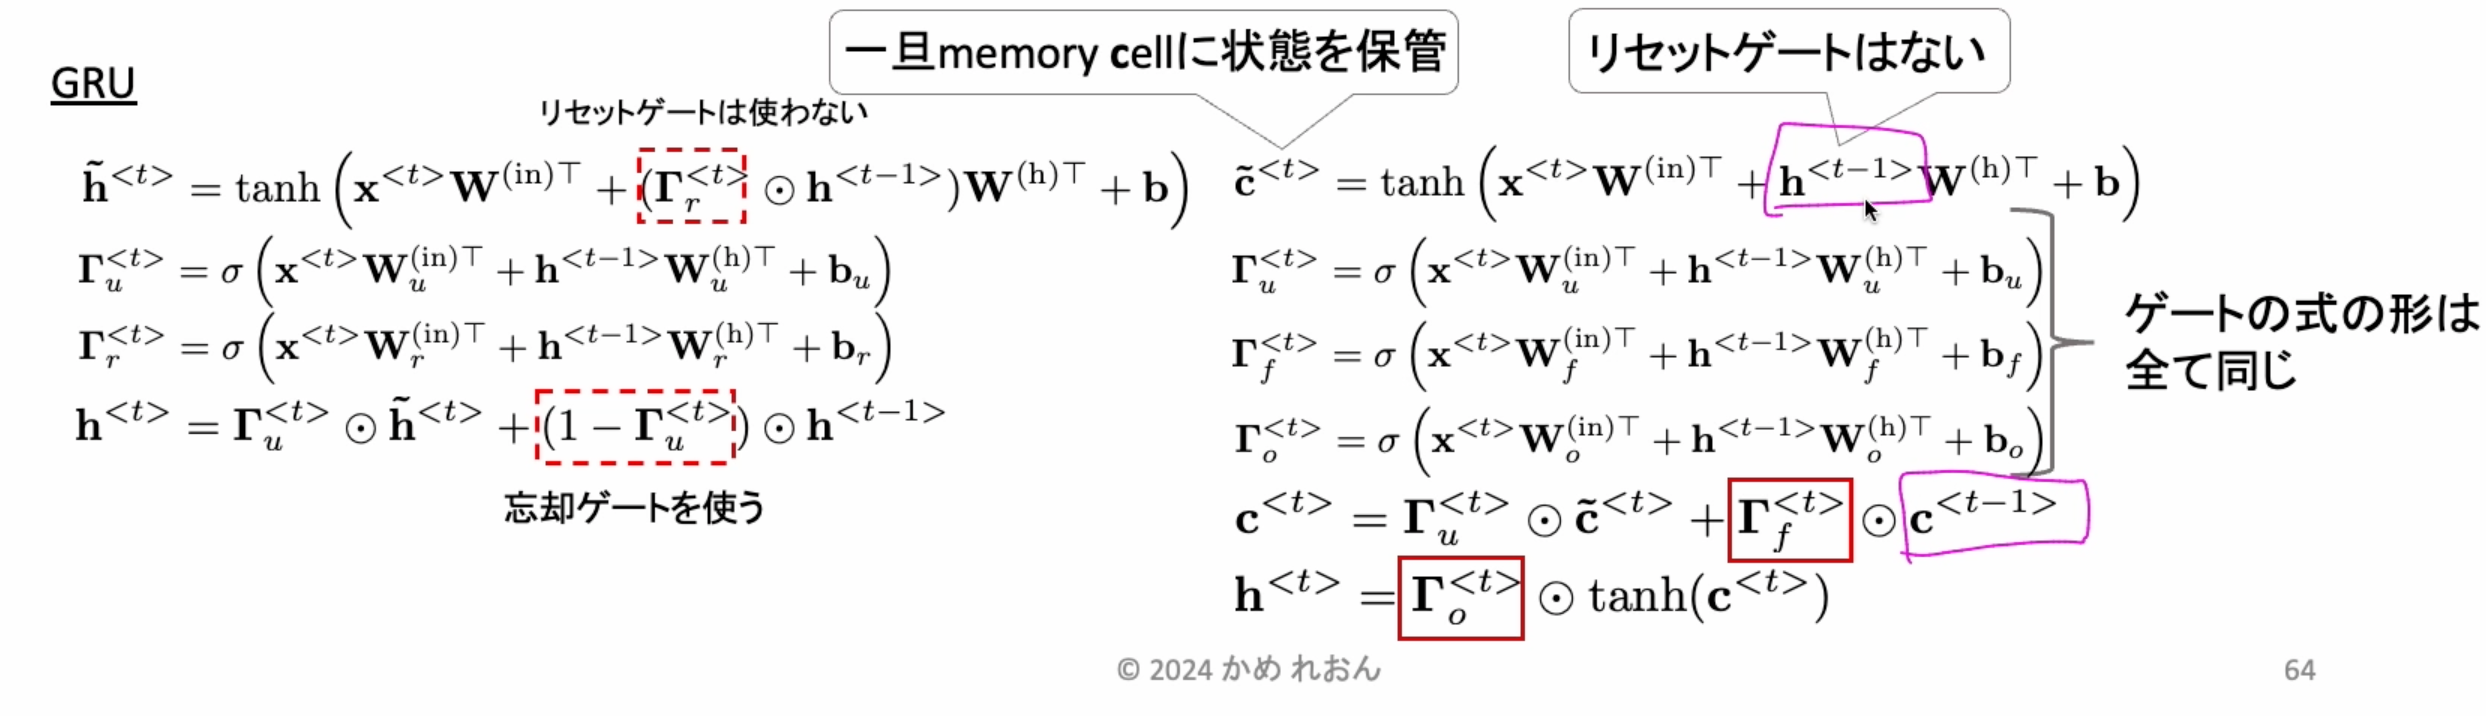

In [5]:
class myLSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size

        # ゲート
        self.update_gate = nn.Linear(input_size+hidden_size, hidden_size)
        self.forget_gate = nn.Linear(input_size+hidden_size, hidden_size)
        self.output_gate = nn.Linear(input_size+hidden_size, hidden_size)

        # セル状態の更新に必要な全結合層
        self.cell_candidate = nn.Linear(input_size+hidden_size, hidden_size)

        # 活性化関数
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()
        
        
    def forward(self, input, h_0=None, c_0=None):
        # input: [batch_size, seq_len, input_size]
        batch_size, self.seq_len, _ = input.size()

        if h_0 is None:
            h_0 = torch.zeros(1, batch_size, self.hidden_size)#.to(device)
        if c_0 is None:
            c_0 = torch.zeros(1, batch_size, self.hidden_size)#.to(device)

        h = h_0.squeeze(0) # [1, batch_size, hidden_size] -> [batch_size, hidden_size]
        c = c_0.squeeze(0) # [1, batch_size, hidden_size] -> [batch_size, hidden_size]
        outputs = []
        for i in range(self.seq_len):
            # [batch_size, hidden_size]
            # h = torch.tanh(input[:, i]@self.W_in.T + self.b_in + h.squeeze(0)@self.W_h.T + self.b_h)
            combined = torch.cat((input[:, i, :], h), dim=1)
            cell_candidate = self.tanh(self.cell_candidate(combined))

            update_gate = self.sigmoid(self.update_gate(combined))
            forget_gate = self.sigmoid(self.forget_gate(combined))
            output_gate = self.sigmoid(self.output_gate(combined))
            
            c = update_gate * cell_candidate + forget_gate * c
            h = output_gate * self.tanh(c)
            
            outputs.append(h.unsqueeze(1))# [batch_size, hidden_size] -> # [batch_size, 1, hidden_size]
        self.output_seq = torch.cat(outputs, dim=1)
        h_n = h.unsqueeze(0) # [batch_size, hidden_size] -> [1, batch_size, hidden_size]
        c_n = c.unsqueeze(0) # [batch_size, hidden_size] -> [1, batch_size, hidden_size]

        return self.output_seq, (h_n, c_n)

In [7]:
# サンプルのTensor
input_size = 10
hidden_size = 3
batch_size = 8
seq_len = 5
input_tensor = torch.randn(batch_size, seq_len, input_size)

# テスト
lstm = myLSTM(input_size, hidden_size)
output_seq, (h_n, c_n) = lstm(input_tensor)

In [8]:
output_seq.shape

torch.Size([8, 5, 3])

In [9]:
h_n.shape

torch.Size([1, 8, 3])

## PytorchのGRUとLSTMを使う

In [15]:
# LSTM
lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
output_seq, (h_n, c_n) = lstm(input_tensor)

print(output_seq.shape)
print(h_n.shape, c_n.shape)

torch.Size([8, 5, 3])
torch.Size([1, 8, 3]) torch.Size([1, 8, 3])


In [19]:
# LSTM
gru = nn.GRU(input_size, hidden_size, batch_first=True)
output_seq, h_n = gru(input_tensor)

print(output_seq.shape)
print(h_n.shape)

torch.Size([8, 5, 3])
torch.Size([1, 8, 3])


In [24]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, rnn_type='LSTM'):

        super().__init__()
        
        if rnn_type == 'RNN':
            self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        elif rnn_type == 'LSTM':
            self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True)
        elif rnn_type == 'GRU':
            self.rnn = nn.GRU(input_size, hidden_size, batch_first=True)
        elif rnn_type == 'UGRNN':
            self.rnn = UGRNN(input_size, hidden_size)
        else:
            raise ValueError('Unsupported RNN type. Choose from ["LSTM", "RNN", "GRU", "UGRNN"]')
            
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        output_seq, _ = self.rnn(x)
        # output_seq: [batch_size, seq_len, hidden_size]
        # h_n: [1, batch_size, hidden_size]
        out = self.fc(output_seq[:, -1, :])
        return out

In [26]:
# サンプルのTensor
input_size = 10
hidden_size = 3
output_size = 3
batch_size = 8
seq_len = 5
input_tensor = torch.randn(batch_size, seq_len, input_size)

model = Model(input_size, hidden_size, output_size, rnn_type='LSTM')
output = model(input_tensor)
print(output.shape)

torch.Size([8, 3])
